In [7]:
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# folder = pathlib.Path('./Kickstarter_2025-10-13T07_42_31_884Z')
# csv_files = folder.glob('Kickstarter*.csv')
# file_path = pathlib.Path('./Kickstarter_2025-10-13T07_42_31_884Z/Kickstarter_merged.csv')
# if file_path.exists():
#     print("File already exists")
# else:    
#     dfs = []
#     for p in csv_files:
#         try:
#             df = pd.read_csv(p)
#             df['source_file'] = p.name
#             dfs.append(df)
#         except Exception as e:
#             print("Failed")

#         merged = pd.concat(dfs, ignore_index=True)
#         out_path = folder / 'Kickstarter_merged.csv'
#         merged.to_csv(out_path, index=False)
#         print(f"Wrote merged CSV to {out_path} with {merged.shape[0]} rows and {merged.shape[1]} columns")

In [8]:
from ast import literal_eval
#######################
#######################
# DATA PREPROCESSING
#######################
#######################
data_df = pd.read_csv('./Kickstarter_2025-10-13T07_42_31_884Z/Kickstarter_merged.csv')

data_df.drop(columns=['creator', 'country_displayable_name', 'currency_symbol', 'currency_trailing_code', 'current_currency', 
                            'disable_communication', 'photo', 'profile', 'source_url', 'urls'])
data_df = data_df[(data_df.state == "successful") | (data_df.state == "failed")]

data_df.drop_duplicates(subset=['id', 'state'], inplace=True)
# Converting datetime objects
data_df['created_at'] = data_df['created_at'].astype(int)
data_df['created_at'] = pd.to_datetime(data_df['created_at'],unit='s')
data_df['deadline'] = data_df['deadline'].astype(int)
data_df['deadline'] = pd.to_datetime(data_df['deadline'], unit='s')
data_df['launched_at'] = data_df['launched_at'].astype(int)
data_df['launched_at'] = pd.to_datetime(data_df['launched_at'],unit='s')
data_df['state_changed_at'] = data_df['state_changed_at'].astype(int)
data_df['state_changed_at'] = pd.to_datetime(data_df['state_changed_at'],unit='s')
# Converting datetime objects
category = data_df.category.apply(literal_eval)
main_category = []
for index, data in enumerate(category):
    try:
        main_category.append(data['parent_name'])
    except:
        main_category.append(np.nan)
data_df['main_category'] = main_category
sub_category = []
for index, name in enumerate(d['name'] for d in category):
    sub_category.append(name)
data_df['sub_category'] = sub_category
data_df.main_category.fillna(data_df.sub_category, inplace=True)
data_df['goal'] = data_df.goal.astype(float)
data_df['fx_rate'] = data_df.fx_rate.astype(float)
data_df['campaign_goal_USD'] = data_df.goal * data_df.fx_rate

data_df.info()

ks = data_df[['id', 'campaign_goal_USD', 'country', 'created_at', 'deadline',  'launched_at', 'state_changed_at',
                  'spotlight', 'main_category', 'sub_category', 'blurb', 'state']]

ks.to_csv("./dist/process_ks.csv", index= False)


/var/folders/43/5fgbl97x0ps7q234n55l5jg40000gn/T/ipykernel_22880/1298958826.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_df.main_category.fillna(data_df.sub_category, inplace=True)


<class 'pandas.core.frame.DataFrame'>
Index: 186372 entries, 0 to 262408
Data columns (total 46 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   backers_count                       186372 non-null  int64         
 1   blurb                               186369 non-null  object        
 2   category                            186372 non-null  object        
 3   converted_pledged_amount            186372 non-null  float64       
 4   country                             186372 non-null  object        
 5   country_displayable_name            186372 non-null  object        
 6   created_at                          186372 non-null  datetime64[ns]
 7   creator                             186372 non-null  object        
 8   currency                            186372 non-null  object        
 9   currency_symbol                     186372 non-null  object        
 10  currency_trai

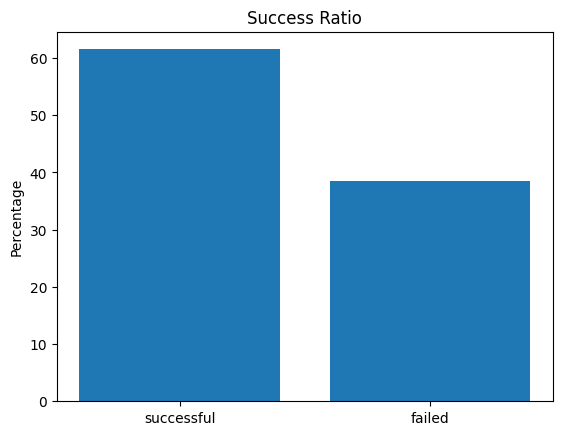

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

process_df= pd.read_csv('./dist/process_ks.csv')
target = process_df.state.value_counts(normalize=True) 
plt.figure()
plt.bar(target.index, target.values)
plt.title('Success Ratio')
plt.ylabel('Percentage')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _pos: f'{x * 100:.0f}'))
plt.savefig('./figures/success-ratio.pdf',bbox_inches='tight')



In [10]:
process_df['state'] = process_df.state.astype(str)
process_df['success'] = np.where(process_df.state == "successful", 1, 0)
process_df.success.value_counts()
process_df.head()

,id,campaign_goal_USD,country,created_at,deadline,launched_at,state_changed_at,spotlight,main_category,sub_category,blurb,state,success
0,905454355,5000.00000,US,2017-02-05 21:31:30,2017-03-31 16:34:32,2017-03-01 17:34:32,2017-03-31 16:34:32,True,Publishing,Radio & Podcasts,A largely-female podcast production team launc...,successful,1
1,1355380918,6300.00000,US,2016-12-30 03:30:54,2017-02-15 04:59:00,2017-01-27 22:38:43,2017-02-15 04:59:02,True,Publishing,Radio & Podcasts,I'm telling you...something happens when you p...,successful,1
2,1990443310,12500.00000,US,2017-01-23 00:30:47,2017-02-25 17:44:49,2017-01-26 17:44:49,2017-02-25 17:44:49,True,Publishing,Radio & Podcasts,Help The Pen Addict record live in Atlanta and...,successful,1
3,1482099881,11620.71830,FR,2021-10-05 19:27:32,2021-12-10 23:19:43,2021-11-08 23:19:43,2021-12-10 23:19:43,True,Photography,Photobooks,Photo book on the youth from neighborhoods in ...,successful,1
4,1486408077,10682.81912,GB,2021-11-04 20:27:52,2021-12-19 20:00:00,2021-11-08 20:50:45,2021-12-19 20:00:01,True,Photography,People,Photography book exploring northern England's ...,successful,1


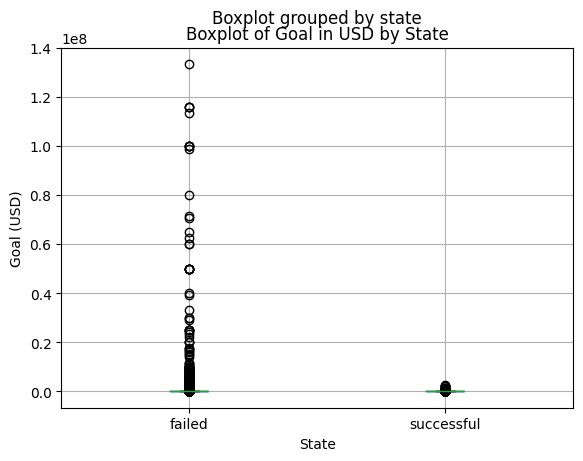

In [11]:
process_df.boxplot(column='campaign_goal_USD', by='state', vert=True)
plt.title('Boxplot of Goal in USD by State')
plt.xlabel('State')
plt.ylabel('Goal (USD)')
plt.savefig('./figures/goal_in_usd.pdf',bbox_inches='tight')



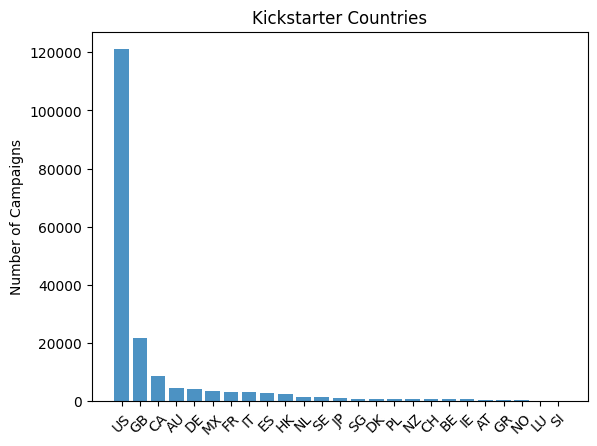

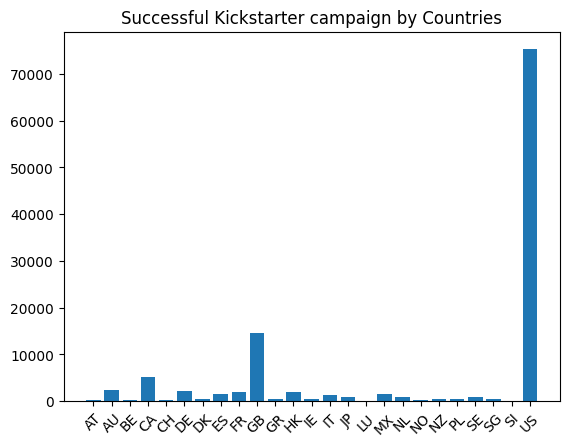

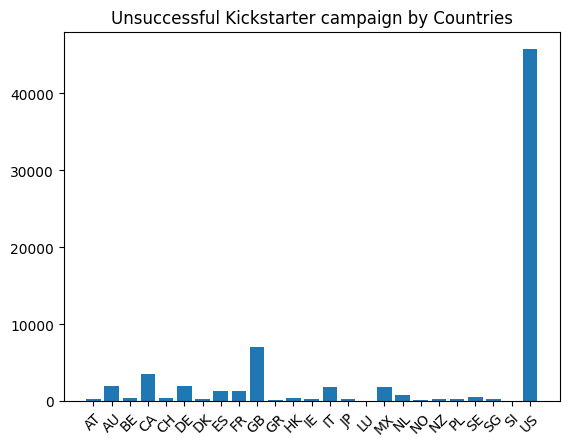

In [12]:
country_list = process_df.country.value_counts()
plt.figure()
plt.bar(country_list.index, country_list.values, alpha=0.8)
plt.title('Kickstarter Countries')
plt.ylabel('Number of Campaigns');
plt.xticks(rotation=45);
plt.savefig('./figures/num_campaigns.pdf',bbox_inches='tight')


country_success = process_df[process_df['state'] == 'successful'].groupby(['country']).size()
plt.figure()
plt.bar(country_success.index, country_success.values)
plt.title('Successful Kickstarter campaign by Countries')
plt.xticks(rotation=45);
plt.savefig('./figures/success_campaigns_by_country.pdf',bbox_inches='tight')

country_success = process_df[process_df['state'] != 'successful'].groupby(['country']).size()
plt.figure()
plt.bar(country_success.index, country_success.values)
plt.title('Unsuccessful Kickstarter campaign by Countries')
plt.xticks(rotation=45);
plt.savefig('./figures/unsuccess_campaigns_by_country.pdf',bbox_inches='tight')


process_df['campaign_location_US'] = np.where(process_df.country == "US", 1, 0)

33.053441504088596


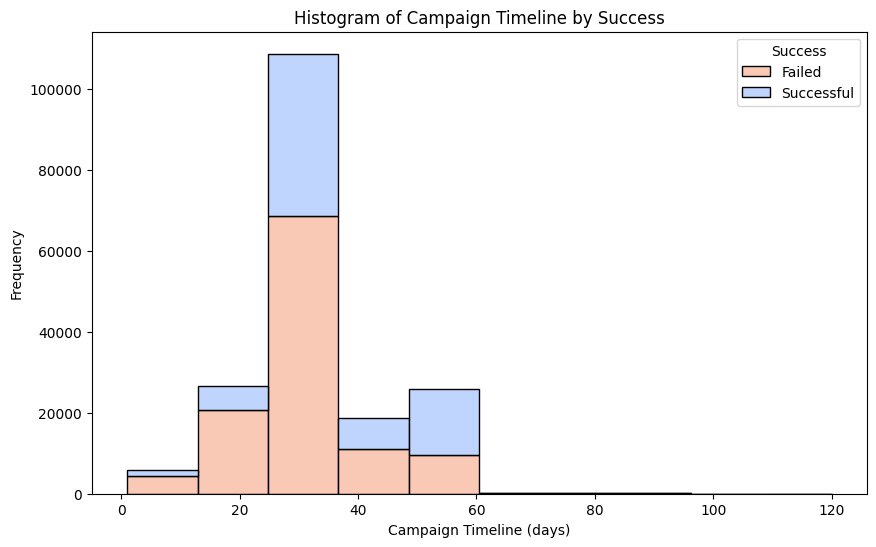

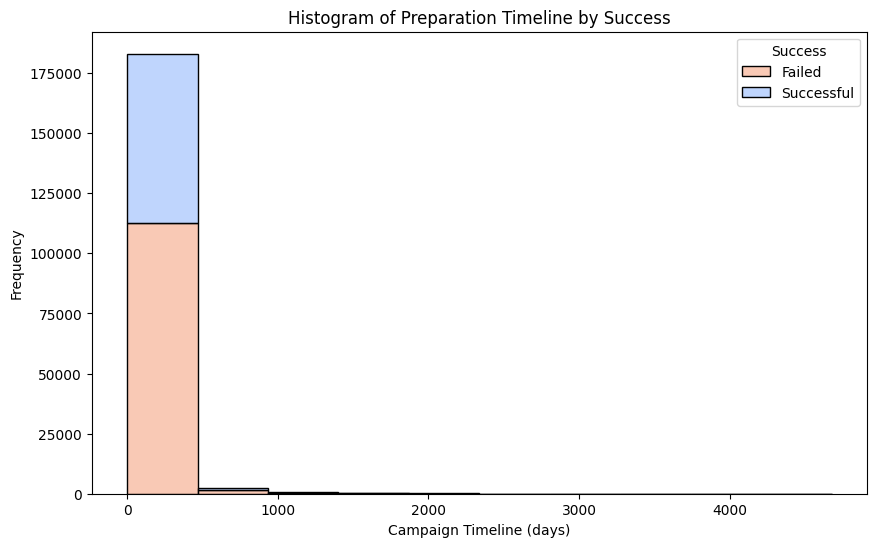

In [13]:
process_df['created_at'] = pd.to_datetime(process_df.created_at)
process_df['launched_at'] = pd.to_datetime(process_df.launched_at)
process_df['deadline'] = pd.to_datetime(process_df.deadline)

prep_date = process_df.created_at.values
start_date = process_df.launched_at.values
end_date = process_df.deadline.values

# campaign duration = from launched time to deadline
process_df['campaign_timeline'] = pd.to_timedelta(end_date - start_date).days
process_df['prep_timeline'] = pd.to_timedelta(start_date - prep_date).days

success_mapping = process_df['state'].map({'successful': 1, 'failed': 0})
print(process_df['campaign_timeline'].mean())

# Create a histogram for campaign_timeline grouped by success
plt.figure(figsize=(10, 6))
sns.histplot(data=process_df, x='campaign_timeline', hue='success', kde=False, bins=10, palette='coolwarm', multiple='stack')
plt.title('Histogram of Campaign Timeline by Success')
plt.xlabel('Campaign Timeline (days)')
plt.ylabel('Frequency')
plt.legend(title='Success', labels=['Failed', 'Successful'])
plt.savefig('./figures/campaign_timeline_histogram.pdf', bbox_inches='tight')
plt.show()

# Create a histogram for campaign_timeline grouped by success
plt.figure(figsize=(10, 6))
sns.histplot(data=process_df, x='prep_timeline', hue='success', kde=False, bins=10, palette='coolwarm', multiple='stack')
plt.title('Histogram of Preparation Timeline by Success')
plt.xlabel('Campaign Timeline (days)')
plt.ylabel('Frequency')
plt.legend(title='Success', labels=['Failed', 'Successful'])
plt.savefig('./figures/prep_timeline_histogram.pdf', bbox_inches='tight')
plt.show()


main_category
Art             11723
Comics           5294
Crafts           3086
Dance            2390
Design           4882
Fashion          5585
Film & Video    17329
Food             5813
Games            9490
Journalism       1545
Music           18322
Photography      3431
Publishing      13226
Technology       8649
Theater          3889
dtype: int64


Index(['id', 'campaign_goal_USD', 'country', 'created_at', 'deadline',
       'launched_at', 'state_changed_at', 'spotlight', 'sub_category', 'blurb',
       'state', 'success', 'campaign_location_US', 'campaign_timeline',
       'prep_timeline', 'main_category_Comics', 'main_category_Crafts',
       'main_category_Dance', 'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater'],
      dtype='object')

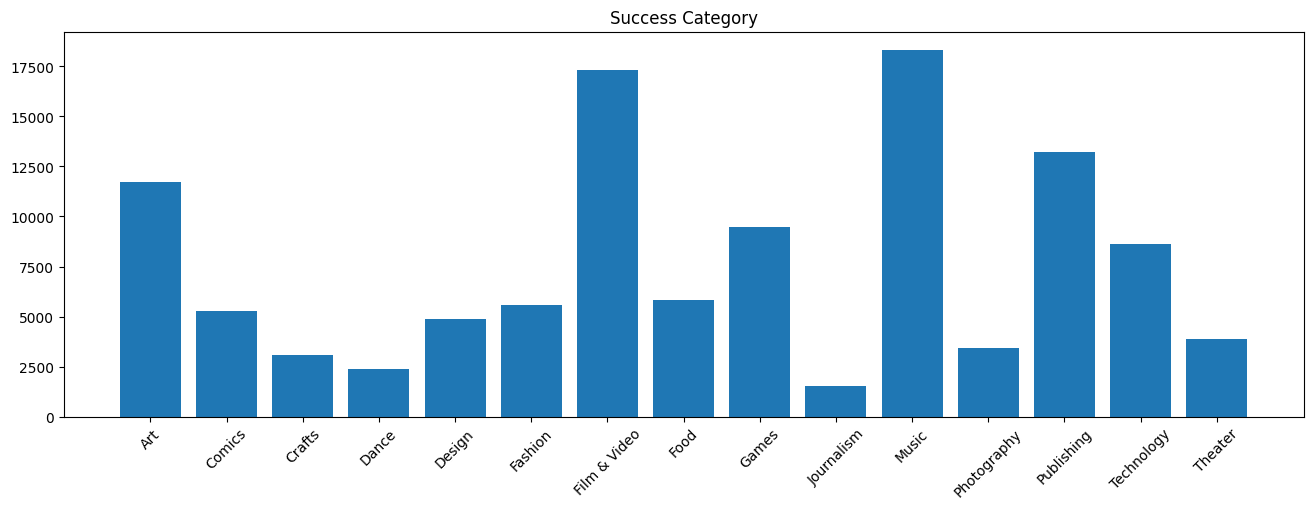

In [14]:
category_success = process_df[process_df['success'] == 1].groupby(['main_category']).size()
print(category_success)
plt.figure(figsize=(16,5))
plt.bar(category_success.index, category_success.values)
plt.title('Success Category')
plt.xticks(rotation=45);

plt.savefig('./figures/success_campaigns_by_category.pdf',bbox_inches='tight')

process_df = pd.get_dummies(columns=['main_category'],dtype=int, drop_first=True, data=process_df)
process_df.columns

In [15]:
process_df.rename(columns={'main_category_Comics': 'Comics',
                   'main_category_Crafts': 'Crafts', 
                   'main_category_Dance': 'Dance', 
                   'main_category_Design': 'Design',
                   'main_category_Fashion': 'Fashion', 
                   'main_category_Film & Video': 'Film_Video',
                   'main_category_Food': 'Food', 
                   'main_category_Games': 'Games', 
                   'main_category_Journalism': 'Journalism',
                   'main_category_Music': 'Music', 
                   'main_category_Photography': 'Photography',
                   'main_category_Publishing': 'Publishing', 
                   'main_category_Technology': 'Technology',
                   'main_category_Theater': 'Theater'}, inplace=True)


In [16]:
def make_confusion_matrix(model, threshold=0.6,name='unknown'):
    y_predict = (model.predict_proba(X_test_sc)[:,1] >=threshold)
    success_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(success_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['fail','success'],
           yticklabels=['fail','success']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    plt.savefig(name,bbox_inches='tight')

In [17]:
features_set = process_df.loc[:,['success', 'campaign_goal_USD', 'campaign_location_US', 'campaign_timeline','prep_timeline',
       'Comics', 'Crafts', 'Dance', 'Design', 'Fashion', 'Film_Video', 'Food',
       'Games', 'Journalism', 'Music', 'Photography', 'Publishing',
       'Technology', 'Theater']]
features_set.head()


,success,campaign_goal_USD,campaign_location_US,campaign_timeline,prep_timeline,Comics,Crafts,Dance,Design,Fashion,Film_Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
0,1,5000.00000,1,29,23,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,6300.00000,1,18,28,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,12500.00000,1,30,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,11620.71830,0,32,34,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,10682.81912,0,40,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0


              precision    recall  f1-score   support

           0       0.66      0.40      0.50     11468
           1       0.70      0.87      0.77     18352

    accuracy                           0.69     29820
   macro avg       0.68      0.64      0.64     29820
weighted avg       0.68      0.69      0.67     29820

Logistic validation metrics: 
 Accuracy: 0.6896 
 Precision: 0.6999 
 Recall: 0.8678 
 F1: 0.7748
0.7160005726673881


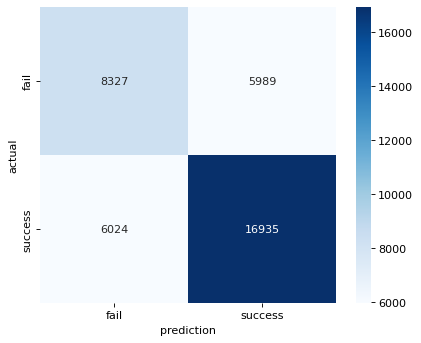

In [18]:


X, y = features_set.drop(['success'], axis=1), features_set.success

X_mid, X_test, y_mid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_mid, y_mid, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train_sc, y_train)
lr_pred = lr.predict(X_val_sc)

lr_ac = lr.score(X_val_sc, y_val)
lr_precision = precision_score(y_val, lr_pred)
lr_recall = recall_score(y_val, lr_pred)
lr_f1 = f1_score(y_val, lr_pred)

print(classification_report(y_val, lr_pred))
make_confusion_matrix(lr,name='./figures/logistic_regression.pdf')

print('Logistic validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (lr_ac, 
         lr_precision, 
         lr_recall,
         lr_f1)
     )

lr_y_score = lr.predict_proba(X_val_sc)[:,1]
lr_fpr, lr_tpr, lr_auc_thresholds = roc_curve(y_val, lr_y_score)
roc_auc_lr = auc(lr_fpr, lr_tpr)
print(roc_auc_lr)

              precision    recall  f1-score   support

           0       0.54      0.57      0.55     11468
           1       0.72      0.70      0.71     18352

    accuracy                           0.65     29820
   macro avg       0.63      0.63      0.63     29820
weighted avg       0.65      0.65      0.65     29820

Decision Tree validation metrics: 
 Accuracy: 0.6470 
 Precision: 0.7206 
 Recall: 0.6965 
 F1: 0.7084
0.6351203033899873


/Users/duahau1/CS533/CProject/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


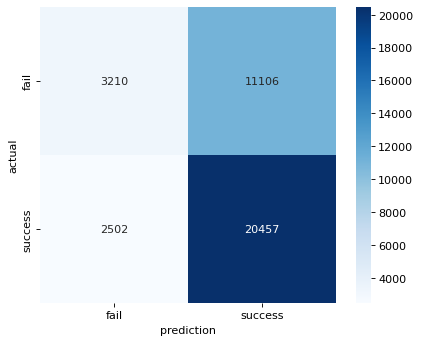

In [19]:

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_val)

dt_ac = dt.score(X_val, y_val)
dt_precision = precision_score(y_val, dt_pred)
dt_recall = recall_score(y_val, dt_pred)
dt_f1 = f1_score(y_val, dt_pred)

print(classification_report(y_val, dt_pred))

print('Decision Tree validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (dt_ac, 
         dt_precision, 
         dt_recall,
         dt_f1)
     )

make_confusion_matrix(dt, name='./figures/decision_tree.pdf')
dt_y_score = dt.predict_proba(X_val)[:, 1]
dt_fpr, dt_tpr, auc_thresholds = roc_curve(y_val, dt_y_score)
roc_auc_dt = auc(dt_fpr, dt_tpr)
print(roc_auc_dt)

              precision    recall  f1-score   support

           0       0.62      0.55      0.58     11468
           1       0.74      0.79      0.76     18352

    accuracy                           0.70     29820
   macro avg       0.68      0.67      0.67     29820
weighted avg       0.69      0.70      0.69     29820

Random Forest validation metrics: 
 Accuracy: 0.6984 
 Precision: 0.7376 
 Recall: 0.7914 
 F1: 0.7636


/Users/duahau1/CS533/CProject/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.7330143566541552


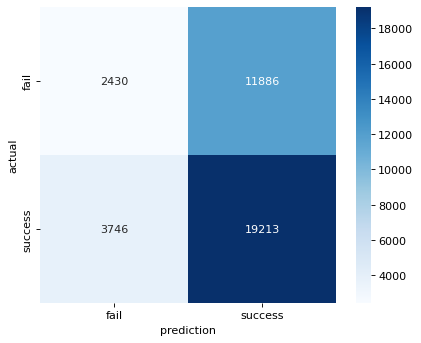

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)
rf_confusion = confusion_matrix(y_val, rf_pred)

rf_ac = rf.score(X_val, y_val)
rf_precision = precision_score(y_val, rf_pred)
rf_recall = recall_score(y_val, rf_pred)
rf_f1 = f1_score(y_val, rf_pred)

print(classification_report(y_val, rf_pred))
print('Random Forest validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (rf_ac, 
         rf_precision, 
         rf_recall,
         rf_f1)
     )
make_confusion_matrix(rf,name='./figures/random_forest.pdf')
rf_pt_y_score = rf.predict_proba(X_val)[:, 1]
rf_pt_fpr, rf_pt_tpr, auc_thresholds = roc_curve(y_val, rf_pt_y_score)
roc_auc_rf_pt = auc(rf_pt_fpr, rf_pt_tpr)
print(roc_auc_rf_pt)

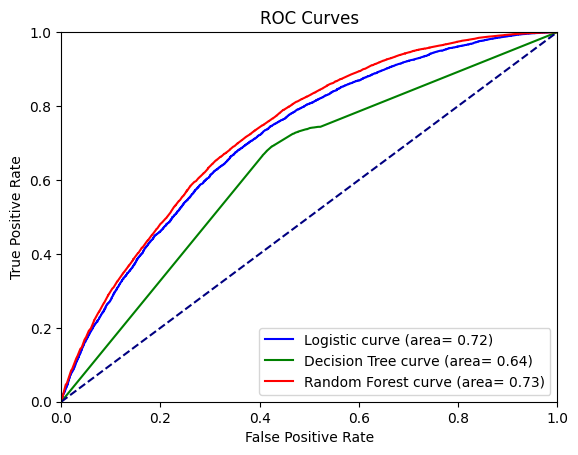

In [ ]:
plt.plot(lr_fpr, lr_tpr, color='blue', 
         label='Logistic curve (area= %0.2f)' %roc_auc_lr)
plt.plot(dt_fpr, dt_tpr, color='green', 
         label='Decision Tree curve (area= %0.2f)' %roc_auc_dt)
plt.plot(rf_pt_fpr, rf_pt_tpr, color='red', 
         label='Random Forest curve (area= %0.2f)' %roc_auc_rf_pt)
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right');
plt.savefig('./figures/roc_curves.pdf',bbox_inches='tight')


In [22]:
# scaler = StandardScaler()
# X_sc = scaler.fit_transform(X_mid)
# X_test_sc = scaler.transform(X_test)
# ##Logistic Regression
# lr.fit(X_sc, y_mid)
# lr_pred = lr.predict(X_test_sc)

# lr_ac = lr.score(X_test_sc, y_test)
# lr_precision = precision_score(y_test, lr_pred)
# lr_recall = recall_score(y_test, lr_pred)
# lr_f1 = f1_score(y_test, lr_pred)

# lr_y_score = lr.predict_proba(X_test_sc)[:,1]
# lr_fpr, lr_tpr, lr_auc_thresholds = roc_curve(y_test, lr_y_score)
# roc_auc_lr = auc(lr_fpr, lr_tpr)

# ##Decision Tree
# dt.fit(X_mid, y_mid)
# dt_pred = dt.predict(X_test)

# dt_ac = dt.score(X_test, y_test)
# dt_precision = precision_score(y_test, dt_pred)
# dt_recall = recall_score(y_test, dt_pred)
# dt_f1 = f1_score(y_test, dt_pred)

# dt_y_score = dt.predict_proba(X_test)[:, 1]
# dt_fpr, dt_tpr, auc_thresholds = roc_curve(y_test, dt_y_score)
# roc_auc_dt = auc(dt_fpr, dt_tpr)

# ##Random Forest
# rf.fit(X_mid, y_mid)
# rf_pred = rf.predict(X_test)
# rf_confusion = confusion_matrix(y_test, rf_pred)

# rf_ac = rf.score(X_test, y_test)
# rf_precision = precision_score(y_test, rf_pred)
# rf_recall = recall_score(y_test, rf_pred)
# rf_f1 = f1_score(y_test, rf_pred)

# rf_y_score = rf.predict_proba(X_test)[:, 1]
# rf_fpr, rf_tpr, auc_thresholds = roc_curve(y_test, rf_y_score)
# roc_auc_rf = auc(rf_fpr, rf_tpr)


# col_list = ['Model_type','accuracy', 'precision', 'recall', 'f1', 'roc']
# lr_dict = dict(zip(col_list, ['Logistic', lr_ac, lr_precision, lr_recall, lr_f1, roc_auc_lr]))
# dt_dict = dict(zip(col_list, ['Decision Tree', dt_ac, dt_precision, dt_recall, dt_f1, roc_auc_dt]))
# rf_dict = dict(zip(col_list, ['Random Forest', rf_ac, rf_precision, rf_recall, rf_f1, roc_auc_rf]))

# score_df = pd.DataFrame([lr_dict, dt_dict, rf_dict])
# score_df

In [23]:
from sklearn.model_selection import GridSearchCV

n_estimators = [10,100,200,300,400,500,600,1000]
criterion = ['gini', 'entropy']
param_grid = dict(n_estimators = n_estimators, criterion = criterion)
rf_grid_search = RandomForestClassifier()
rf_grid = GridSearchCV(rf_grid_search, param_grid=param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_grid_preds = rf_grid.predict(X_val)
rf_best_params = rf_grid.best_params_
rf_best_estimator = rf_grid.best_estimator_
rf_best_cm = confusion_matrix(y_val,rf_grid_preds)
rf_best_cr = classification_report(y_val,rf_grid_preds)
print(rf_best_params, rf_best_estimator, rf_best_cm, rf_best_cr)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ....................criterion=gini, n_estimators=10; total time=   1.2s
[CV] END ....................criterion=gini, n_estimators=10; total time=   1.2s
[CV] END ....................criterion=gini, n_estimators=10; total time=   1.3s
[CV] END ....................criterion=gini, n_estimators=10; total time=   1.3s
[CV] END ....................criterion=gini, n_estimators=10; total time=   1.3s
[CV] END ....................criterion=gini, n_estimators=10; total time=   1.2s
[CV] END ....................criterion=gini, n_estimators=10; total time=   1.2s
[CV] END ....................criterion=gini, n_estimators=10; total time=   1.3s
[CV] END ....................criterion=gini, n_estimators=10; total time=   1.3s
[CV] END ....................criterion=gini, n_estimators=10; total time=   1.3s
[CV] END ...................criterion=gini, n_estimators=100; total time=  12.4s
[CV] END ...................criterion=gini, n_es

/Users/duahau1/CS533/CProject/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ................criterion=entropy, n_estimators=100; total time=  16.5s
[CV] END ................criterion=entropy, n_estimators=100; total time=  16.0s
[CV] END ................criterion=entropy, n_estimators=100; total time=  16.0s
[CV] END ................criterion=entropy, n_estimators=100; total time=  15.9s
[CV] END ................criterion=entropy, n_estimators=100; total time=  15.9s
[CV] END ................criterion=entropy, n_estimators=200; total time=  35.0s
[CV] END ................criterion=entropy, n_estimators=200; total time=  35.0s
[CV] END ................criterion=entropy, n_estimators=200; total time=  37.7s
[CV] END ................criterion=entropy, n_estimators=200; total time=  37.7s
[CV] END ................criterion=entropy, n_estimators=200; total time=  40.4s
[CV] END ................criterion=entropy, n_estimators=200; total time=  40.4s
[CV] END ..................criterion=gini, n_estimators=1000; total time= 2.9min
[CV] END ..................c

In [28]:
import pickle
filename = 'random_forest_model.pkl'
rf_pt = RandomForestClassifier(criterion='entropy', n_estimators=500)
rf_pt.fit(X_train, y_train)
rf_pt_pred = rf_pt.predict(X_val)
rf_pt_ac = rf_pt.score(X_val, y_val)
rf_pt_precision = precision_score(y_val, rf_pt_pred)
rf_pt_recall = recall_score(y_val, rf_pt_pred)
rf_pt_f1 = f1_score(y_val, rf_pt_pred)
print('Random Forest after tuned validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (rf_pt_ac, 
         rf_pt_precision, 
         rf_pt_recall,
         rf_pt_f1)
     )
rf_pt_y_score = rf_pt.predict_proba(X_val)[:, 1]
rf_pt_fpr, rf_pt_tpr, auc_thresholds = roc_curve(y_val, rf_pt_y_score)
roc_auc_rf_pt = auc(rf_pt_fpr, rf_pt_tpr)
print(roc_auc_rf_pt)

pickle.dump(rf, open(filename, 'wb'))


Random Forest after tuned validation metrics: 
 Accuracy: 0.7003 
 Precision: 0.7371 
 Recall: 0.7975 
 F1: 0.7661
0.7351400833265165
0.7351400833265165
